In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Torch-Version 2.5.1+cu121
DEVICE: cuda


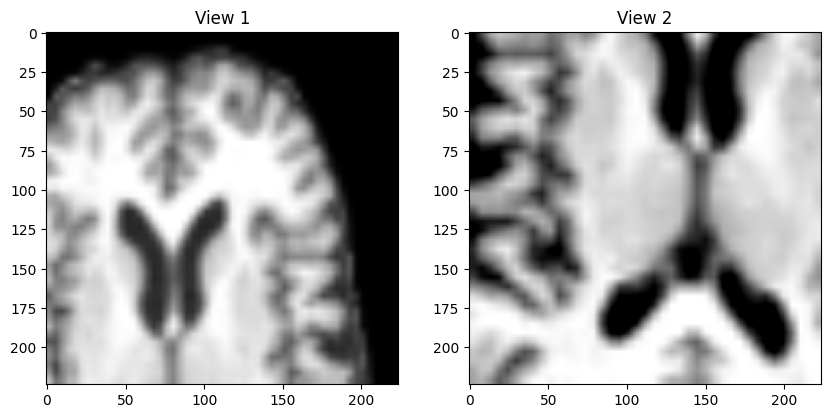

In [2]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import (
    RandomResizedCrop,
    RandomHorizontalFlip,
    ColorJitter,
    RandomGrayscale,
    RandomApply,
    Compose,
    GaussianBlur,
    ToTensor,
)
import matplotlib.pyplot as plt
import numpy as np

print(f'Torch-Version {torch.__version__}')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'DEVICE: {DEVICE}')

# Define the image transformation
def get_complete_transform(output_shape, kernel_size, s=1.0):
    rnd_crop = RandomResizedCrop(output_shape)
    rnd_flip = RandomHorizontalFlip(p=0.5)
    color_jitter = ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
    rnd_color_jitter = RandomApply([color_jitter], p=0.8)
    rnd_gray = RandomGrayscale(p=0.2)
    gaussian_blur = GaussianBlur(kernel_size=kernel_size)
    rnd_gaussian_blur = RandomApply([gaussian_blur], p=0.5)
    to_tensor = ToTensor()
    image_transform = Compose([
        to_tensor,
        rnd_crop,
        rnd_flip,
        rnd_color_jitter,
        rnd_gray,
        rnd_gaussian_blur,
    ])
    return image_transform

# Custom class for generating contrastive views
class ContrastiveLearningViewGenerator(object):
    def __init__(self, base_transform, n_views=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):
        views = [self.base_transform(x) for _ in range(self.n_views)]
        return views

# Custom Dataset class for .npy files
class CustomNpyDataset(Dataset):
    def __init__(self, data_path, transform=None):
        """
        Args:
            data_path (str): Path to the .npy file containing the data.
            transform (callable, optional): Transformations to be applied.
        """
        self.data = np.load(data_path)[:, 1, :, :]  # Discard the first channel and keep the second
        self.data = self.data / 255.0  # Normalize to [0, 1]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        if self.transform:
            # Convert to a format that torchvision transforms can handle
            image = image.numpy().squeeze(0)
            image = self.transform(image)
        return image

# The size of the images and transformation parameters
output_shape = [224, 224]
kernel_size = [21, 21]  # 10% of the output shape

# The custom transform
base_transforms = get_complete_transform(output_shape=output_shape, kernel_size=kernel_size, s=1.0)
custom_transform = ContrastiveLearningViewGenerator(base_transform=base_transforms)

# Instantiate dataset for training data
train_images_path = "/content/drive/MyDrive/Brain_images/brain_train_image_final.npy"
ssl_train_ds = CustomNpyDataset(data_path=train_images_path, transform=custom_transform)

# Visualize the data
plt.figure(figsize=(10, 20))

def view_data(dataset, index):
    images = dataset[index]
    view1, view2 = images
    for i, (view, title) in enumerate(zip([view1, view2], ["View 1", "View 2"])):
        plt.subplot(1, 2, i + 1)
        plt.imshow(view.permute(1, 2, 0), cmap='gray')
        plt.title(title)

view_data(ssl_train_ds, 0)
plt.show()

In [3]:
import torch
import torch.nn as nn
from torchvision import models  # Import models from torchvision
from torch.utils.data import DataLoader
import os
import time

BATCH_SIZE = 128

# Build the data loader
train_dl = torch.utils.data.DataLoader(
    ssl_train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)

# Identity layer (used in SimCLR)
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

class SimCLR(nn.Module):
    def __init__(self, linear_eval=False):
        super().__init__()
        self.linear_eval = linear_eval
        resnet18 = models.resnet18(weights=None)  # ResNet18 backbone without pretrained weights

        # Modify the first convolutional layer to accept 1 channel
        resnet18.conv1 = nn.Conv2d(
            in_channels=1,  # Single channel (grayscale)
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )

        resnet18.fc = Identity()  # Remove the final FC layer
        self.encoder = resnet18
        self.projection = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
        )

    def forward(self, x):
        if not self.linear_eval:
            x = torch.cat(x, dim=0)  # Concatenate views for both branches
        encoding = self.encoder(x)  # Forward pass through ResNet18
        projection = self.projection(encoding)  # Forward pass through projection head
        return projection

# Precompute Labels for the Loss Function
LABELS = torch.cat([torch.arange(BATCH_SIZE) for _ in range(2)], dim=0)
LABELS = (LABELS.unsqueeze(0) == LABELS.unsqueeze(1)).float()  # Create a one-hot encoding
LABELS = LABELS.to(DEVICE)

# Contrastive Loss (NT-Xent)
def cont_loss(features, temp):
    similarity_matrix = torch.matmul(features, features.T)  # Similarity matrix (128x128)
    mask = torch.eye(LABELS.shape[0], dtype=torch.bool).to(DEVICE)
    labels = LABELS[~mask].view(LABELS.shape[0], -1)  # Remove diagonal (self-similarity)
    similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)

    positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)  # Extract positives
    negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)  # Extract negatives

    logits = torch.cat([positives, negatives], dim=1)  # Combine positives and negatives
    labels = torch.zeros(logits.shape[0], dtype=torch.long).to(DEVICE)  # Positive labels (first column)
    logits = logits / temp  # Scale logits by temperature
    return logits, labels

# Instantiate SimCLR Model, Loss Function, and Optimizer
simclr_model = SimCLR().to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(simclr_model.parameters(), lr=3e-4)

# Training Loop
EPOCHS = 100
for epoch in range(EPOCHS):
    t0 = time.time()
    running_loss = 0.0

    for i, views in enumerate(train_dl):
        projections = simclr_model([view.to(DEVICE) for view in views])  # Forward pass
        logits, labels = cont_loss(projections, temp=0.5)  # Contrastive loss
        loss = criterion(logits, labels)  # CrossEntropy loss

        optimizer.zero_grad()  # Zero gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters

        running_loss += loss.item()

        # Print statistics for every 10 batches
        if i % 10 == 9:
            print(f'EPOCH: {epoch + 1}, BATCH: {i + 1}, LOSS: {running_loss / 10:.4f}')
            running_loss = 0.0

    print(f"Epoch {epoch + 1} completed in {(time.time() - t0) / 60:.3f} mins")



EPOCH: 1, BATCH: 10, LOSS: 10.7883
Epoch 1 completed in 0.190 mins
EPOCH: 2, BATCH: 10, LOSS: 5.5647
Epoch 2 completed in 0.147 mins
EPOCH: 3, BATCH: 10, LOSS: 5.5479
Epoch 3 completed in 0.177 mins
EPOCH: 4, BATCH: 10, LOSS: 5.5438
Epoch 4 completed in 0.162 mins
EPOCH: 5, BATCH: 10, LOSS: 5.5447
Epoch 5 completed in 0.164 mins
EPOCH: 6, BATCH: 10, LOSS: 5.5435
Epoch 6 completed in 0.164 mins
EPOCH: 7, BATCH: 10, LOSS: 5.5394
Epoch 7 completed in 0.167 mins
EPOCH: 8, BATCH: 10, LOSS: 5.5443
Epoch 8 completed in 0.157 mins
EPOCH: 9, BATCH: 10, LOSS: 5.5391
Epoch 9 completed in 0.163 mins
EPOCH: 10, BATCH: 10, LOSS: 5.5360
Epoch 10 completed in 0.153 mins
EPOCH: 11, BATCH: 10, LOSS: 5.5314
Epoch 11 completed in 0.163 mins
EPOCH: 12, BATCH: 10, LOSS: 5.5299
Epoch 12 completed in 0.165 mins
EPOCH: 13, BATCH: 10, LOSS: 5.5110
Epoch 13 completed in 0.158 mins
EPOCH: 14, BATCH: 10, LOSS: 5.5192
Epoch 14 completed in 0.168 mins
EPOCH: 15, BATCH: 10, LOSS: 5.5153
Epoch 15 completed in 0.157 mi

In [4]:
from torchvision.transforms import (
    CenterCrop,
    Resize,
    ToTensor,
    Normalize,
    RandomHorizontalFlip,
    Compose,
)
from torchvision.models import resnet18, ResNet18_Weights
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from PIL import Image

# Define transformations
custom_transform = Compose([
    Resize(255),
    CenterCrop(224),
    RandomHorizontalFlip(p=0.5),  # Add minimal augmentation
    ToTensor(),
    Normalize(mean=[0.5], std=[0.5]),  # Normalize grayscale images
])

# Dataset class
class NpyDatasetWithLabels(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.images = np.load(images_path)[:, 1, :, :] / 255.0  # Normalize images
        self.labels = np.load(labels_path)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = Image.fromarray((image * 255).astype(np.uint8))  # Convert to PIL
        if self.transform:
            image = self.transform(image)
        return image, label

# Paths to images and labels
train_images_path = "/content/drive/MyDrive/Brain_images/brain_train_image_final.npy"
train_labels_path = "/content/drive/MyDrive/Brain_images/brain_train_label.npy"

# Instantiate dataset and dataloader
train_dataset = NpyDatasetWithLabels(
    images_path=train_images_path,
    labels_path=train_labels_path,
    transform=custom_transform,
)

nu_classes = len(np.unique(np.load(train_labels_path)))
print("Number of classes: ", nu_classes)

BATCH_SIZE = 128
train_dl = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)

# Pretrained ResNet18 encoder
pretrained_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
pretrained_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Adjust for grayscale
pretrained_model.fc = Identity()

# Linear evaluation model with dropout
class LinearEvaluation(nn.Module):
    def __init__(self, model, nu_classes):
        super().__init__()
        self.encoder = model
        self.encoder.linear_eval = True
        self.encoder.projection = Identity()
        self.linear = nn.Sequential(
            nn.Dropout(0.5),  # Add dropout
            nn.Linear(512, nu_classes),
        )

    def forward(self, x):
        encoding = self.encoder(x)
        pred = self.linear(encoding)
        return pred

eval_model = LinearEvaluation(pretrained_model, nu_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(eval_model.parameters(), lr=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=50)

# Training loop
EPOCHS = 50
for epoch in range(EPOCHS):
    eval_model.train()
    total_loss, correct = 0, 0

    for i, (image, label) in enumerate(train_dl):
        image, label = image.to(DEVICE), label.to(DEVICE)

        # Forward pass
        pred = eval_model(image)
        loss = criterion(pred, label)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accuracy calculation
        total_loss += loss.item()
        correct += (pred.argmax(dim=1) == label).sum().item()

    scheduler.step()

    accuracy = correct / len(train_dataset)
    print(f'Epoch {epoch + 1}/{EPOCHS}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}')


Number of classes:  3


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]


Epoch 1/50, Loss: 14.5186, Accuracy: 0.3156
Epoch 2/50, Loss: 13.6221, Accuracy: 0.3543
Epoch 3/50, Loss: 13.1399, Accuracy: 0.4098
Epoch 4/50, Loss: 12.5593, Accuracy: 0.4345
Epoch 5/50, Loss: 12.1388, Accuracy: 0.4484
Epoch 6/50, Loss: 12.0437, Accuracy: 0.4786
Epoch 7/50, Loss: 11.2914, Accuracy: 0.5094
Epoch 8/50, Loss: 10.7235, Accuracy: 0.5238
Epoch 9/50, Loss: 10.2090, Accuracy: 0.5558
Epoch 10/50, Loss: 9.4169, Accuracy: 0.5969
Epoch 11/50, Loss: 8.5820, Accuracy: 0.6343
Epoch 12/50, Loss: 7.9957, Accuracy: 0.6626
Epoch 13/50, Loss: 7.3527, Accuracy: 0.6886
Epoch 14/50, Loss: 6.5655, Accuracy: 0.7248
Epoch 15/50, Loss: 5.3196, Accuracy: 0.7743
Epoch 16/50, Loss: 4.3678, Accuracy: 0.8057
Epoch 17/50, Loss: 3.8264, Accuracy: 0.8087
Epoch 18/50, Loss: 3.1275, Accuracy: 0.8455
Epoch 19/50, Loss: 2.4787, Accuracy: 0.8612
Epoch 20/50, Loss: 1.8243, Accuracy: 0.8865
Epoch 21/50, Loss: 1.3109, Accuracy: 0.8950
Epoch 22/50, Loss: 1.2068, Accuracy: 0.9028
Epoch 23/50, Loss: 0.7270, Accur

In [6]:
# Paths to test data
test_images_path = "/content/drive/MyDrive/Brain_images/brain_test_image_final.npy"
test_labels_path = "/content/drive/MyDrive/Brain_images/brain_test_label.npy"

# Test dataset
test_dataset = NpyDatasetWithLabels(
    images_path=test_images_path,
    labels_path=test_labels_path,
    transform=custom_transform,
)

# Test dataloader
test_dl = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=os.cpu_count(),
    pin_memory=True,
)

# Evaluate on the test set
eval_model.eval()  # Set model to evaluation mode
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_dl:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = eval_model(images)
        preds = torch.argmax(outputs, axis=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Test Accuracy: 54.61%


In [7]:
from torchvision.transforms import (
    CenterCrop,
    Resize,
    ToTensor,
    Normalize,
    RandomHorizontalFlip,
    Compose,
)
from torchvision.models import resnet50, ResNet50_Weights
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from PIL import Image

# Define transformations
custom_transform = Compose([
    Resize(255),
    CenterCrop(224),
    RandomHorizontalFlip(p=0.5),  # Add minimal augmentation
    ToTensor(),
    Normalize(mean=[0.5], std=[0.5]),  # Normalize grayscale images
])

# Dataset class
class NpyDatasetWithLabels(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.images = np.load(images_path)[:, 1, :, :] / 255.0  # Normalize images
        self.labels = np.load(labels_path)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = Image.fromarray((image * 255).astype(np.uint8))  # Convert to PIL
        if self.transform:
            image = self.transform(image)
        return image, label

# Paths to images and labels
train_images_path = "/content/drive/MyDrive/Brain_images/brain_train_image_final.npy"
train_labels_path = "/content/drive/MyDrive/Brain_images/brain_train_label.npy"

# Instantiate dataset and dataloader
train_dataset = NpyDatasetWithLabels(
    images_path=train_images_path,
    labels_path=train_labels_path,
    transform=custom_transform,
)

nu_classes = len(np.unique(np.load(train_labels_path)))
print("Number of classes: ", nu_classes)

BATCH_SIZE = 128
train_dl = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)

# Pretrained ResNet50 encoder
pretrained_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
pretrained_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Adjust for grayscale
pretrained_model.fc = nn.Identity()  # Remove the final fully connected layer

# Linear evaluation model with dropout
class LinearEvaluation(nn.Module):
    def __init__(self, model, nu_classes):
        super().__init__()
        self.encoder = model
        self.linear = nn.Sequential(
            nn.Dropout(0.5),  # Add dropout
            nn.Linear(2048, nu_classes),  # Update input features to match ResNet50's output
        )

    def forward(self, x):
        encoding = self.encoder(x)
        pred = self.linear(encoding)
        return pred

eval_model = LinearEvaluation(pretrained_model, nu_classes).to('cuda')
criterion = nn.CrossEntropyLoss().to('cuda')
optimizer = optim.Adam(eval_model.parameters(), lr=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=50)

# Training loop
EPOCHS = 50
for epoch in range(EPOCHS):
    eval_model.train()
    total_loss, correct = 0, 0

    for i, (image, label) in enumerate(train_dl):
        image, label = image.to('cuda'), label.to('cuda')

        # Forward pass
        pred = eval_model(image)
        loss = criterion(pred, label)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accuracy calculation
        total_loss += loss.item()
        correct += (pred.argmax(dim=1) == label).sum().item()

    scheduler.step()

    accuracy = correct / len(train_dataset)
    print(f'Epoch {epoch + 1}/{EPOCHS}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}')


Number of classes:  3


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]


Epoch 1/50, Loss: 13.3671, Accuracy: 0.3398
Epoch 2/50, Loss: 12.7389, Accuracy: 0.4019
Epoch 3/50, Loss: 12.3077, Accuracy: 0.4225
Epoch 4/50, Loss: 11.8600, Accuracy: 0.4695
Epoch 5/50, Loss: 11.0063, Accuracy: 0.5335
Epoch 6/50, Loss: 10.0231, Accuracy: 0.5709
Epoch 7/50, Loss: 9.8876, Accuracy: 0.5782
Epoch 8/50, Loss: 8.3076, Accuracy: 0.6584
Epoch 9/50, Loss: 7.1745, Accuracy: 0.7055
Epoch 10/50, Loss: 6.5818, Accuracy: 0.7284
Epoch 11/50, Loss: 5.0672, Accuracy: 0.7749
Epoch 12/50, Loss: 4.3734, Accuracy: 0.7918
Epoch 13/50, Loss: 3.2038, Accuracy: 0.8334
Epoch 14/50, Loss: 2.8989, Accuracy: 0.8461
Epoch 15/50, Loss: 2.2963, Accuracy: 0.8690
Epoch 16/50, Loss: 1.4862, Accuracy: 0.8890
Epoch 17/50, Loss: 1.2053, Accuracy: 0.8938
Epoch 18/50, Loss: 1.0375, Accuracy: 0.9028
Epoch 19/50, Loss: 0.8679, Accuracy: 0.9071
Epoch 20/50, Loss: 0.7193, Accuracy: 0.9113
Epoch 21/50, Loss: 0.5598, Accuracy: 0.9185
Epoch 22/50, Loss: 0.3342, Accuracy: 0.9228
Epoch 23/50, Loss: 0.2326, Accuracy

In [8]:
from torchvision.transforms import (
    CenterCrop,
    Resize,
    ToTensor,
    Normalize,
    Compose,
)
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch

# Define transformations
resize = Resize(255)
ccrop = CenterCrop(224)
ttensor = ToTensor()

custom_transform = Compose([
    resize,
    ccrop,
    ttensor,
    Normalize(mean=[0.5], std=[0.5]),  # Normalize for grayscale
])

# Custom Dataset class
class NpyDatasetWithLabels(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.images = np.load(images_path)[:, 1, :, :] / 255.0  # Discard first channel and normalize
        self.labels = np.load(labels_path)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = Image.fromarray((image * 255).astype(np.uint8))  # Convert to PIL
        if self.transform:
            image = self.transform(image)
        return image, label

# Paths to test dataset
test_images_path = "/content/drive/MyDrive/Brain_images/brain_test_image_final.npy"
test_labels_path = "/content/drive/MyDrive/Brain_images/brain_test_label.npy"

# Instantiate test dataset and dataloader
test_dataset = NpyDatasetWithLabels(
    images_path=test_images_path,
    labels_path=test_labels_path,
    transform=custom_transform,
)

BATCH_SIZE = 128
test_dl = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No shuffling for evaluation
    num_workers=os.cpu_count(),
    pin_memory=True,
)

# Evaluate the model on the test dataset
eval_model.eval()  # Ensure the model is in evaluation mode
criterion = torch.nn.CrossEntropyLoss().to("cuda")  # Define the loss function

t0 = time.time()
running_loss = 0.0
correct = 0
total = 0

for i, (images, labels) in enumerate(test_dl):
    images, labels = images.to("cuda"), labels.to("cuda")
    with torch.no_grad():  # Disable gradient computation
        predictions = eval_model(images)  # Forward pass
        loss = criterion(predictions, labels)  # Compute loss
        running_loss += loss.item()

        # Calculate accuracy
        correct += (torch.argmax(predictions, dim=1) == labels).sum().item()
        total += labels.size(0)

    print(f"Batch {i + 1}/{len(test_dl)}, Loss: {running_loss / (i + 1):.4f}, Accuracy: {correct / total * 100:.2f}%")

print(f"Final Test Accuracy: {correct / total * 100:.2f}%")
print(f"Time taken: {((time.time() - t0) / 60):.3f} mins")


Batch 1/3, Loss: 1.7699, Accuracy: 57.81%
Batch 2/3, Loss: 1.7156, Accuracy: 60.16%
Batch 3/3, Loss: 1.5093, Accuracy: 62.12%
Final Test Accuracy: 62.12%
Time taken: 0.010 mins


In [13]:
# Paths to images and labels
train_images_path = "/content/drive/MyDrive/Brain_images/brain_train_image_final.npy"
train_labels_path = "/content/drive/MyDrive/Brain_images/brain_train_label.npy"
test_images_path = "/content/drive/MyDrive/Brain_images/brain_test_image_final.npy"
test_labels_path = "/content/drive/MyDrive/Brain_images/brain_test_label.npy"

# Custom Dataset Class for Labeled Data
class CustomNpyLabeledDataset(Dataset):
    def __init__(self, data_path, labels_path, transform=None):
        """
        Args:
            data_path (str): Path to the .npy file containing images.
            labels_path (str): Path to the .npy file containing labels.
            transform (callable, optional): Transformations to be applied.
        """
        self.data = np.load(data_path)[:, 1, :, :] / 255.0  # Use second channel, normalize
        self.labels = np.load(labels_path).astype(np.int64)  # Ensure labels are integers
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        if self.transform:
            image = self.transform(image.numpy().squeeze(0))
        return image, label


# Transforms for evaluation
eval_transform = torchvision.transforms.Compose([
    ToTensor(),
    RandomResizedCrop(output_shape),  # Resized to the desired output shape
])

# Datasets and DataLoaders
train_dataset = CustomNpyLabeledDataset(train_images_path, train_labels_path, transform=eval_transform)
test_dataset = CustomNpyLabeledDataset(test_images_path, test_labels_path, transform=eval_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

# Instantiate Linear Classifier
num_classes = 3
linear_classifier = LinearClassifier(encoder=simclr_model.encoder, num_classes=num_classes).to(DEVICE)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(linear_classifier.classifier.parameters(), lr=3e-4)

# Training the Classifier
EPOCHS = 50
for epoch in range(EPOCHS):
    linear_classifier.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = linear_classifier(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{EPOCHS}], Loss: {running_loss / len(train_loader):.4f}')

# Evaluate on Test Data
linear_classifier.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = linear_classifier(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')


Epoch [1/50], Loss: 1.1101
Epoch [2/50], Loss: 1.0485
Epoch [3/50], Loss: 1.0318
Epoch [4/50], Loss: 1.0227
Epoch [5/50], Loss: 1.0229
Epoch [6/50], Loss: 1.0131
Epoch [7/50], Loss: 1.0116
Epoch [8/50], Loss: 1.0149
Epoch [9/50], Loss: 1.0191
Epoch [10/50], Loss: 1.0090
Epoch [11/50], Loss: 1.0062
Epoch [12/50], Loss: 1.0034
Epoch [13/50], Loss: 1.0033
Epoch [14/50], Loss: 1.0080
Epoch [15/50], Loss: 1.0099
Epoch [16/50], Loss: 1.0011
Epoch [17/50], Loss: 1.0029
Epoch [18/50], Loss: 1.0092
Epoch [19/50], Loss: 1.0033
Epoch [20/50], Loss: 1.0031
Epoch [21/50], Loss: 0.9987
Epoch [22/50], Loss: 1.0044
Epoch [23/50], Loss: 0.9985
Epoch [24/50], Loss: 0.9996
Epoch [25/50], Loss: 1.0058
Epoch [26/50], Loss: 1.0148
Epoch [27/50], Loss: 1.0048
Epoch [28/50], Loss: 0.9992
Epoch [29/50], Loss: 1.0066
Epoch [30/50], Loss: 0.9973
Epoch [31/50], Loss: 1.0024
Epoch [32/50], Loss: 1.0025
Epoch [33/50], Loss: 1.0012
Epoch [34/50], Loss: 1.0043
Epoch [35/50], Loss: 0.9939
Epoch [36/50], Loss: 1.0039
E